In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms

In [2]:
class CNNCifar10(nn.Module):
    def __init__(self):
        super(CNNCifar10, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=2, stride=1), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=2, stride=2), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3872, 128)
        )

        self.z_mean = nn.Linear(128, 2)
        self.z_log_var = nn.Linear(128, 2)

        self.decoder = nn.Sequential(
            nn.Linear(2, 3872),
            nn.ReLU(),
            nn.Unflatten(1, (32, 11, 11)),
			      nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)
        dec = self.decoder(lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + std * eps

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

trainset = CIFAR10(root='~/data', train=True, download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=16)
testset = CIFAR10(root='~/data', train=False, download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=256, shuffle=False, num_workers=16)

print(len(trainset), len(testset))
print(len(train_dl), len(test_dl))

Files already downloaded and verified
Files already downloaded and verified
50000 10000
196 40


In [4]:
def gaussian_kls(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return torch.mean(kld_loss)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNNCifar10().to(device)

optimizer = Adam(params = model.parameters(), lr=0.001)

recon_loss = nn.BCELoss(reduction='none')

def loss_fn(recon_x, x):
    return torch.mean(torch.sum(recon_loss(recon_x, x), dim=(1,2,3)))

In [6]:
for epoch in range(30):
    model.train()
    tr_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        tr_total_loss["rec_loss"] += train_rec_loss.item()
        tr_total_loss["kl_loss"] += train_kl_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = {
            "rec_loss" : 0,
            "kl_loss" : 0
        }
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss["rec_loss"] += valid_rec_loss.item()
            va_total_loss["kl_loss"] += valid_kl_loss.item()

    print(f"Epoch: {epoch} - TrainRecLoss: {tr_total_loss['rec_loss']/len(train_dl)} - ValidRecLoss: {va_total_loss['rec_loss']/len(test_dl)}")
    print(f"Epoch: {epoch} - TrainDivLoss: {tr_total_loss['kl_loss']/len(train_dl)} - ValidDivLoss: {va_total_loss['kl_loss']/len(test_dl)}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:33<00:00,  1.21it/s]


Epoch: 0 - TrainRecLoss: 2031.046043551698 - ValidRecLoss: 1976.5648040771484
Epoch: 0 - TrainDivLoss: 5.358797348897943 - ValidDivLoss: 6.428823006153107


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.23it/s]


Epoch: 1 - TrainRecLoss: 1968.8993841677295 - ValidRecLoss: 1969.265542602539
Epoch: 1 - TrainDivLoss: 6.248074950004111 - ValidDivLoss: 6.010941255092621


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.22it/s]


Epoch: 2 - TrainRecLoss: 1965.7440540547273 - ValidRecLoss: 1969.0209350585938
Epoch: 2 - TrainDivLoss: 5.904494560494715 - ValidDivLoss: 5.82672393321991


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:33<00:00,  1.21it/s]


Epoch: 3 - TrainRecLoss: 1964.1939765774473 - ValidRecLoss: 1968.1741912841796
Epoch: 3 - TrainDivLoss: 5.770092049423529 - ValidDivLoss: 5.736959981918335


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.22it/s]


Epoch: 4 - TrainRecLoss: 1964.0471110441247 - ValidRecLoss: 1967.0359161376953
Epoch: 4 - TrainDivLoss: 5.650816087820092 - ValidDivLoss: 5.587355744838715


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.22it/s]


Epoch: 5 - TrainRecLoss: 1963.6716844208386 - ValidRecLoss: 1966.2022216796875
Epoch: 5 - TrainDivLoss: 5.57909801054974 - ValidDivLoss: 5.476285994052887


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.22it/s]


Epoch: 6 - TrainRecLoss: 1963.1949880171796 - ValidRecLoss: 1966.2475860595703
Epoch: 6 - TrainDivLoss: 5.510120150994282 - ValidDivLoss: 5.379274678230286


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.22it/s]


Epoch: 7 - TrainRecLoss: 1963.285184899155 - ValidRecLoss: 1965.5671417236329
Epoch: 7 - TrainDivLoss: 5.445384225066827 - ValidDivLoss: 5.386826145648956


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.22it/s]


Epoch: 8 - TrainRecLoss: 1962.8428849200814 - ValidRecLoss: 1965.8891693115233
Epoch: 8 - TrainDivLoss: 5.39841002347518 - ValidDivLoss: 5.30996344089508


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.22it/s]


Epoch: 9 - TrainRecLoss: 1962.8977891571667 - ValidRecLoss: 1965.3325958251953
Epoch: 9 - TrainDivLoss: 5.345162075393054 - ValidDivLoss: 5.325800573825836


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.22it/s]


Epoch: 10 - TrainRecLoss: 1962.5646306251992 - ValidRecLoss: 1965.855484008789
Epoch: 10 - TrainDivLoss: 5.30800200481804 - ValidDivLoss: 5.3109007477760315


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.23it/s]


Epoch: 11 - TrainRecLoss: 1962.4598986567282 - ValidRecLoss: 1965.957260131836
Epoch: 11 - TrainDivLoss: 5.287942039723299 - ValidDivLoss: 5.164067709445954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.25it/s]


Epoch: 12 - TrainRecLoss: 1962.3855210907604 - ValidRecLoss: 1965.4828002929687
Epoch: 12 - TrainDivLoss: 5.259579140312818 - ValidDivLoss: 5.265469443798065


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.25it/s]


Epoch: 13 - TrainRecLoss: 1962.3464299416055 - ValidRecLoss: 1965.0402465820312
Epoch: 13 - TrainDivLoss: 5.238778182438442 - ValidDivLoss: 5.1849863767623905


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.24it/s]


Epoch: 14 - TrainRecLoss: 1962.0313789211973 - ValidRecLoss: 1964.9461547851563
Epoch: 14 - TrainDivLoss: 5.209756999599691 - ValidDivLoss: 5.134521842002869


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.24it/s]


Epoch: 15 - TrainRecLoss: 1962.211484947983 - ValidRecLoss: 1965.4840179443358
Epoch: 15 - TrainDivLoss: 5.205198460695695 - ValidDivLoss: 5.1953373670578005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.21it/s]


Epoch: 16 - TrainRecLoss: 1961.931383405413 - ValidRecLoss: 1964.9992645263671
Epoch: 16 - TrainDivLoss: 5.187165625241338 - ValidDivLoss: 5.115410006046295


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.21it/s]


Epoch: 17 - TrainRecLoss: 1961.9306042729593 - ValidRecLoss: 1964.7440979003907
Epoch: 17 - TrainDivLoss: 5.188849497814568 - ValidDivLoss: 5.291500401496887


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.21it/s]


Epoch: 18 - TrainRecLoss: 1961.906788728675 - ValidRecLoss: 1964.8125274658203
Epoch: 18 - TrainDivLoss: 5.174777388572693 - ValidDivLoss: 5.226415431499481


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.21it/s]


Epoch: 19 - TrainRecLoss: 1961.9174779775192 - ValidRecLoss: 1964.8312194824218
Epoch: 19 - TrainDivLoss: 5.168329168339165 - ValidDivLoss: 5.150166952610016


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.22it/s]


Epoch: 20 - TrainRecLoss: 1961.6260768345423 - ValidRecLoss: 1964.6096496582031
Epoch: 20 - TrainDivLoss: 5.156492646859617 - ValidDivLoss: 5.187478268146515


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.22it/s]


Epoch: 21 - TrainRecLoss: 1961.9290553501673 - ValidRecLoss: 1964.678872680664
Epoch: 21 - TrainDivLoss: 5.166800114573265 - ValidDivLoss: 5.151222109794617


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.22it/s]


Epoch: 22 - TrainRecLoss: 1961.3511147012516 - ValidRecLoss: 1964.2794616699218
Epoch: 22 - TrainDivLoss: 5.183528690922017 - ValidDivLoss: 5.288005816936493


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.22it/s]


Epoch: 23 - TrainRecLoss: 1961.5198320661273 - ValidRecLoss: 1964.3026458740235
Epoch: 23 - TrainDivLoss: 5.1690361913369625 - ValidDivLoss: 5.15143107175827


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.22it/s]


Epoch: 24 - TrainRecLoss: 1961.3789554518096 - ValidRecLoss: 1964.4033416748048
Epoch: 24 - TrainDivLoss: 5.182323234421866 - ValidDivLoss: 5.119142532348633


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.22it/s]


Epoch: 25 - TrainRecLoss: 1961.5104289152184 - ValidRecLoss: 1964.5741790771485
Epoch: 25 - TrainDivLoss: 5.16121878429335 - ValidDivLoss: 5.333537578582764


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.22it/s]


Epoch: 26 - TrainRecLoss: 1961.4136084731745 - ValidRecLoss: 1964.6229125976563
Epoch: 26 - TrainDivLoss: 5.1691195770185825 - ValidDivLoss: 5.075352668762207


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:32<00:00,  1.21it/s]


Epoch: 27 - TrainRecLoss: 1961.2261414819834 - ValidRecLoss: 1964.3278564453126
Epoch: 27 - TrainDivLoss: 5.172670447096532 - ValidDivLoss: 5.014359092712402


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:33<00:00,  1.21it/s]


Epoch: 28 - TrainRecLoss: 1961.0578731614717 - ValidRecLoss: 1964.5024108886719
Epoch: 28 - TrainDivLoss: 5.171126278079286 - ValidDivLoss: 5.165791189670562


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:33<00:00,  1.20it/s]

Epoch: 29 - TrainRecLoss: 1961.3236320651308 - ValidRecLoss: 1964.0809814453125
Epoch: 29 - TrainDivLoss: 5.162834182077525 - ValidDivLoss: 5.158716237545013


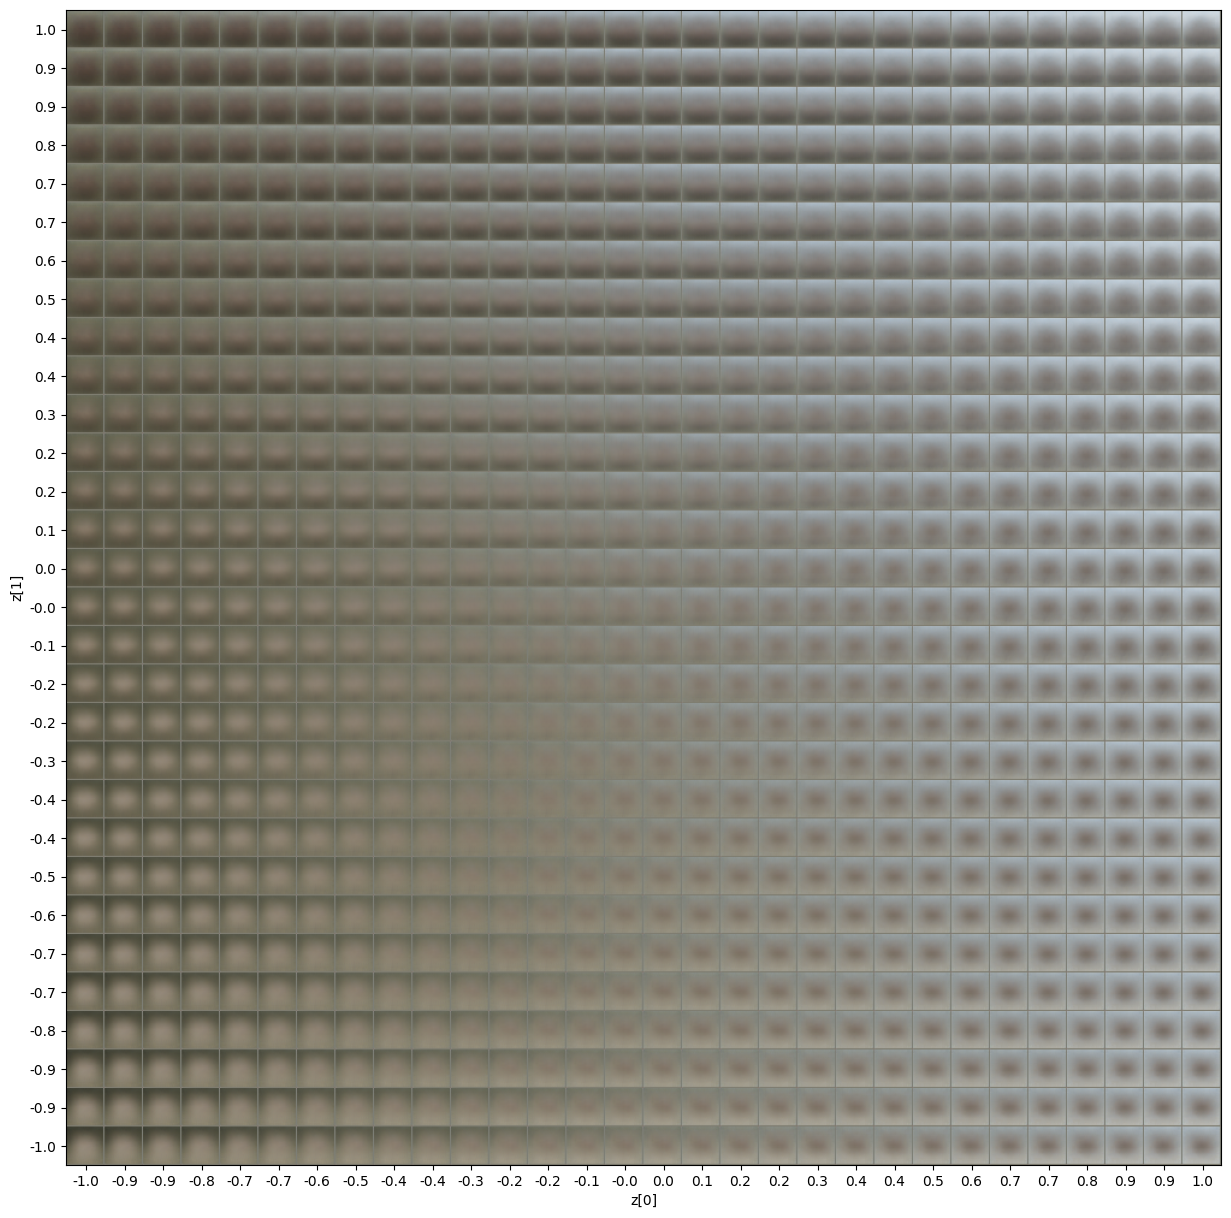

In [13]:
size = 32
scale = 1.0
n = 30
figure = np.zeros((size * n, size * n, 3))

grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = torch.tensor([[xi, yi]]).to(device, dtype=torch.float)
        x_decoded = model.decoder(z_sample)
        digit = x_decoded[0].permute(1, -1, 0).detach().cpu().numpy()
        figure[
            i * size : (i + 1) * size,
            j * size : (j + 1) * size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = size // 2
end_range = n * size + start_range
pixel_range = np.arange(start_range, end_range, size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x) 
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap="Greys_r")
plt.show()